In [7]:
%pylab inline
import sim as vrep
import time
import cv2
import numpy as np

Populating the interactive namespace from numpy and matplotlib


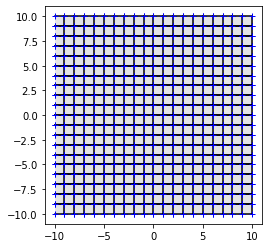

In [8]:
# Tha map is 20x20 sq meters
#Lets define a grid of nxn
n = 20
gmap = zeros(n*n) # the map is a grid of nxn

# x and y coordinates for the grid cells. Lowest and leftest point in the cell.
cell_w = 1
grid_x, grid_y = np.mgrid[-n/2:n/2:cell_w,-n/2:n/2:cell_w]
# Convert the matrix into a vector
grid_x = grid_x.flatten()
grid_y = grid_y.flatten()

# Computes the four points of the square that composes a cell
def points_cell(x, y, d):    
    X = [x, x+d, x+d, x]
    Y = [y, y, y+d, y+d]
    return X, Y

fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# plot each cell
for x, y in zip(grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='0.9')
    
    ax.add_patch(cell)

    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    
fig.canvas.draw()

In [9]:
def detect_and_store_circles(img, euler):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray,5)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, gray.shape[0] / 8,
                               param1=30,param2=15,minRadius=10,maxRadius=0)
    for circle in circles[0, :]:
        arr_circle.append([circle, euler[2]])

def compute(arr_circle):
    u0, v0 = 132, 132
    l0 = (0.3/(1-0.3))  # Initial belief
    gmap = l0 * ones(n*n) # Initial belief      
    for circle in arr_circle :
        center = (circle[0][0], circle[0][1])
        radius = circle[0][2]
        k = radius / (1.5 / 2)  # Pixels per meters (radius in pixels / radius in  meters)
        fov = 60  # degrees
        npx = 264 # number of pixels in x-axis
        xmax = npx / (2.* k) # maximum value in the x-axis (in meters)
        zc = xmax / tan(pi/6) # Distance to the center of the sphere (z-axis coordinate)
        xc = (center[0] - u0) / k # Location of the sphere in the x-axis coordinate
        xc, zc
        alpha = circle[1] - pi/2
        r = np.array(( (np.cos(alpha), -np.sin(alpha)),
               (np.sin(alpha),  np.cos(alpha)) ))
        v = np.array((xc,zc))
        xc, zc = r.dot(v)
        # For each cell, check if the circle is in it.
        for i in range(n*n):
            x, y = grid_x[i], grid_y[i]
            #TODO Run this for each sphere (center and radius)
            # Corners of the cell
            X, Y = points_cell(x, y, cell_w)
            # check based on the ecuclidean distance
            dist = sqrt((xc - X)**2 + (zc - Y)**2)
            # Check if At least one of the borders is within the sphere
            if((dist < radius/k).any()):
                po = 0.8  # P(mi/zt) probability of having an obstacle 
                li = log(po / (1-po)) + gmap[i] - l0
                gmap[i] = li  # P(mi/zt) 
            else:
                po = 0.05  # P(mi/zt) probability of having an obstacle given a non-detected obstacle
                # Cells within the fov. Check if the four points are withing the FOV
#                 thetas = np.arctan2(Y,X) - circle[1]
#                 if np.logical_and(-pi/6 <thetas, thetas < pi/6).all():
#                     li = log(po / (1-po)) + gmap[i] - l0
#                     gmap[i] = li
                pass
    return gmap

In [10]:
vrep.simxFinish(-1)

clientID = vrep.simxStart('127.0.0.1', 19999, True, True, 5000, 5)

if clientID!=-1:
    res, v1 = vrep.simxGetObjectHandle(clientID, 'Vision_sensor', vrep.simx_opmode_oneshot_wait)
    res, r1 = vrep.simxGetObjectHandle(clientID, 'Pioneer_p3dx', vrep.simx_opmode_oneshot_wait)
    err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_streaming)
    p = 10  # Take p pictures
    i = 0
    arr_circle = []
    while i < p:     
        err, resolution, image = vrep.simxGetVisionSensorImage(clientID, v1, 0, vrep.simx_opmode_buffer)
        res, euler = vrep.simxGetObjectOrientation(clientID, r1, -1, vrep.simx_opmode_streaming)
        if err == vrep.simx_return_ok:
            print ("image %d OK!!!"%i)
            img = np.array(image,dtype=np.uint8)
            img.resize([resolution[1],resolution[0],3])
            detect_and_store_circles(img, euler)
            i+=1
        elif err == vrep.simx_return_novalue_flag:
            print ("no image yet")
            pass
        else:
              print (err)
        time.sleep(5)
else:
    print ("Failed to connect to remote API Server")
    vrep.simxFinish(clientID)

no image yet
image 0 OK!!!
image 1 OK!!!
image 2 OK!!!
image 3 OK!!!
image 4 OK!!!
image 5 OK!!!
image 6 OK!!!
image 7 OK!!!
image 8 OK!!!
image 9 OK!!!


In [11]:
arr_circle

[[array([114.5, 149.5,  46.3], dtype=float32), 1.5013176202774048],
 [array([183.5, 138.5,  26.3], dtype=float32), 0.9776389002799988],
 [array([249.5, 153.5,  60.7], dtype=float32), 0.5118836760520935],
 [array([ 76.5, 140.5,  24.9], dtype=float32), 0.5118836760520935],
 [array([123.5, 151.5,  53.3], dtype=float32), -0.016160568222403526],
 [array([125.5, 139.5,  28.4], dtype=float32), -0.5767226219177246],
 [array([195.5, 137.5,  23.5], dtype=float32), -1.0436153411865234],
 [array([ 12.5, 136.5,  37.3], dtype=float32), -1.0436153411865234],
 [array([ 67.5, 137.5,  23.5], dtype=float32), -1.6050808429718018],
 [array([255.5, 162.5,  27.7], dtype=float32), -1.6050808429718018],
 [array([106.5, 146.5,  38.6], dtype=float32), -2.263399600982666],
 [array([157.5, 136.5,  22.9], dtype=float32), -2.263399600982666],
 [array([231.5, 141.5,  32.1], dtype=float32), -2.837218999862671],
 [array([ 23.5, 140.5,  27.8], dtype=float32), -2.837218999862671],
 [array([ 64.5, 142.5,  33. ], dtype=flo

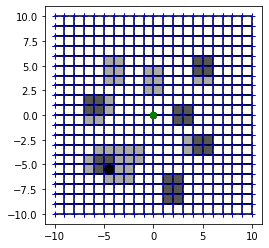

In [12]:
gmap = compute(arr_circle)
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')
# normalize gmap
gmap = gmap - min(gmap)
gmap = gmap / max(gmap)
for c, x, y in zip(gmap, grid_x, grid_y):
    X, Y = points_cell(x, y, cell_w)
    cell = plt.Polygon([(xi, yi) for xi, yi in zip(X,Y)], color='%f'%(1-c))
    ax.add_patch(cell)
    plot(X,Y, 'k-')
    plot(X,Y, 'b+')    
    plot(0,0, 'go')
    # plot each cell
    fig.canvas.draw() 